In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
# from torchinfo import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod
# math
import math

In [2]:
# What are you trying to do?
create_new_model = True
create_new_res = True
# If create_new_model is True, epochs must have a value
epochs = 3
# If create_new_model is False, load_model_name must have a value
load_model_name = 'model_2021-2-19_2250.pt'
ecg_saved_res = 'res_pt_full_2021-2-20_111.npy'
# Normalization option (either option 0 or 1)
norm_option = 2

In [3]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e03.npy')).cuda().double()
ecg_clean = torch.from_numpy(np.load('all_none_fs1024_e24.npy')).cuda().double()

# Acquire original shape
x = ecg_noisy.shape[0]
y = ecg_noisy.shape[2]
z = ecg_noisy.shape[1]

# Reshape
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_clean = torch.reshape( ecg_clean, (x, y, z))

ecg_noisy = et.norm_basic( ecg_noisy )
ecg_clean = et.norm_basic( ecg_clean )

ecg_noisy = et.realign_starting(ecg_noisy, ecg_clean)

Diff: tensor([[-0.1365, -0.1443, -0.1430,  ..., -0.1007, -0.1022, -0.1105]],
       device='cuda:0', dtype=torch.float64)
tensor([[0.1871, 0.1842, 0.1871,  ..., 0.0877, 0.1023, 0.1053]],
       device='cuda:0', dtype=torch.float64) - tensor([[0.1871, 0.1842, 0.1871,  ..., 0.0877, 0.1023, 0.1053]],
       device='cuda:0', dtype=torch.float64)
tensor([[0.1871, 0.1842, 0.1871,  ..., 0.0877, 0.1023, 0.1053]],
       device='cuda:0', dtype=torch.float64) - tensor([[0.1871, 0.1842, 0.1871,  ..., 0.0877, 0.1023, 0.1053]],
       device='cuda:0', dtype=torch.float64)


In [4]:
# # =============== LOAD ECG DATA ===============
# ecg_noisy = np.load('all_none_fs1024_e06.npy')#.flatten()
# ecg_clean = np.load('all_none_fs1024_e24.npy')

# # Acquire original shape
# x = ecg_clean.shape[0]
# y = ecg_clean.shape[2]
# z = ecg_clean.shape[1]
# # Continue flattening
# # ecg_clean = ecg_clean.flatten()

# ecg_noisy = torch.from_numpy(ecg_noisy).cuda().double()
# ecg_clean = torch.from_numpy(ecg_clean).cuda().double()

# # RESHAPE BACK INTO APPROPRIATE SHAPE
# ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
# ecg_clean = torch.reshape( ecg_clean, (x, y, z))

# # Normalize ecg_clean per subset
# ecg_noisy = et.norm_sig(ecg_noisy)
# ecg_clean = et.norm_sig(ecg_clean)

# # # RESHAPE BACK INTO APPROPRIATE SHAPE
# # ecg_noisy = torch.reshape(torch.from_numpy(ecg_noisy), (x, y, z)).cuda().double()
# # ecg_clean = torch.reshape(torch.from_numpy(ecg_clean), (x, y, z)).cuda().double()

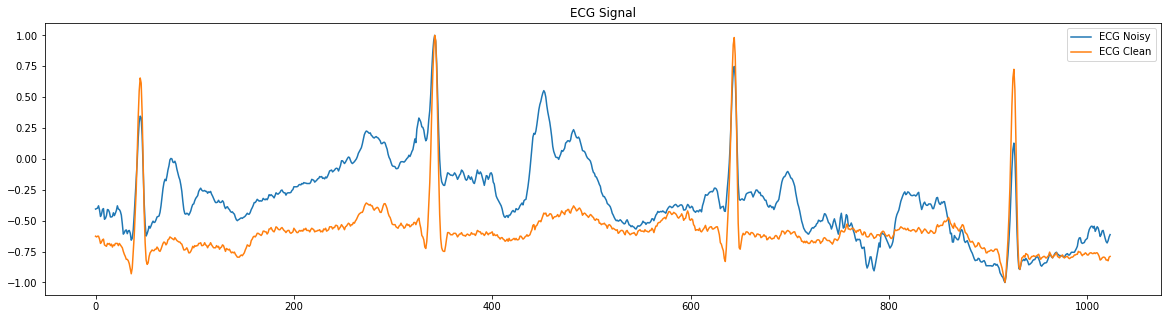

In [5]:
et.ecg_plot( [ecg_noisy.cpu().flatten(), ecg_clean.cpu().flatten()], ['ECG Noisy', 'ECG Clean'], index = 0)

In [6]:
# Train a new model
if create_new_model:
    # move model to be run by gpu
    model = mod.ae_sampler().cuda()
    model.double()
    # start training the model
    losses = tr.train_model( model=model,
                    epochs=epochs, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_clean,
                    train_pct=0.8)
    save_file_name = 'model_' + str(et.get_local_time()) + '.pt';
    # saved model will have model_YYYY-MM-DD_hhmm.pt format
    torch.save(model.state_dict(), save_file_name)
    print(f'Saved {et.get_local_time()}')
# load model instead if existing
else:
    model = mod.ae_sampler().cuda()
    model.double()
    model.load_state_dict(torch.load(load_model_name))
    model.to('cuda')
    model.eval()
    print( f'Model {load_model_name} has been loaded')

train_size[4435] + valid_size[1109]= 5544
same size
Epoch 1 of 3 || time: 69.37 || loss = 0.17802734820306787
Epoch 2 of 3 || time: 65.57 || loss = 0.10300497539525685
Epoch 3 of 3 || time: 65.16 || loss = 0.09926793008004402
Elapsed time: 200.11, (in mins: 3:20)
Validation dataset has not been used: Available validex set size = 1109
Saved 2021-2-20_2233


In [7]:
if create_new_model == True or create_new_res == True:
    ecg_res = et.concat_pt_full(model, ecg_noisy)
    et.get_local_time()
else:
    ecg_res = np.load( ecg_saved_res )

ecg_res = ecg_res.flatten()

Result size: (4000, 1, 1024)
Result size: (1544, 1, 1024)
Complete shape is: (5544, 1, 1024)
Filename: res_pt_full_2021-2-20_2233


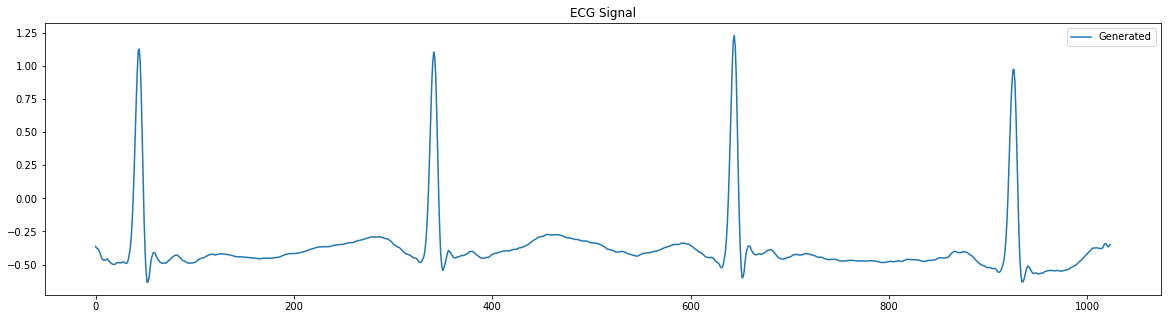

In [8]:
et.ecg_plot( [ecg_res], ['Generated'])

In [9]:
# ecg_res = ecg_res.flatten()
# ecg_res = et.realign_starting(ecg_res, ecg_clean_flat)

In [10]:
# ecg_res1 = np.load('res_pt_full_2021-2-19_1813.npy').flatten()
# ecg_res2 = np.load('res_pt_full_2021-2-19_1815.npy').flatten()
# ecg_res3 = np.load('res_pt_full_2021-2-19_1953.npy').flatten()
# ecg_res4 = np.load('res_pt_full_2021-2-19_2044.npy').flatten()

In [11]:
# ecg_res1 = et.realign_starting(ecg_res1, ecg_clean_flat)
# ecg_res2 = et.realign_starting(ecg_res2, ecg_clean_flat)
# ecg_res3 = et.realign_starting(ecg_res3, ecg_clean_flat)
# ecg_res4 = et.realign_starting(ecg_res4, ecg_clean_flat)

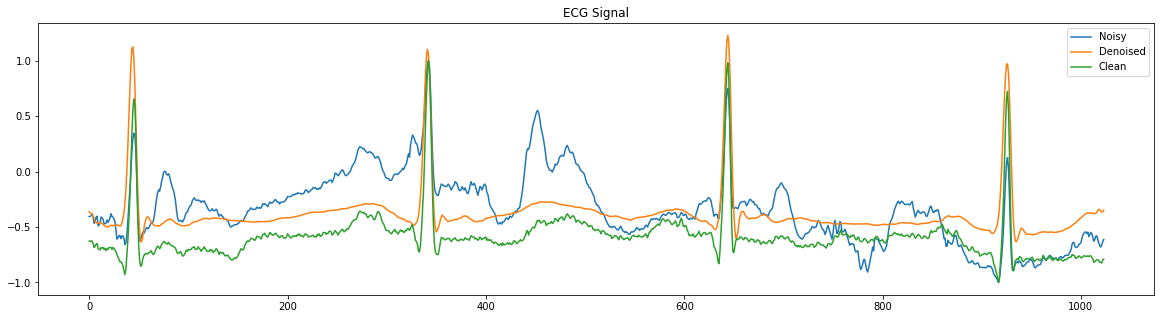

In [12]:
et.ecg_plot( [ecg_noisy.cpu().flatten(), ecg_res, ecg_clean.cpu().flatten()], ['Noisy', 'Denoised', 'Clean'])

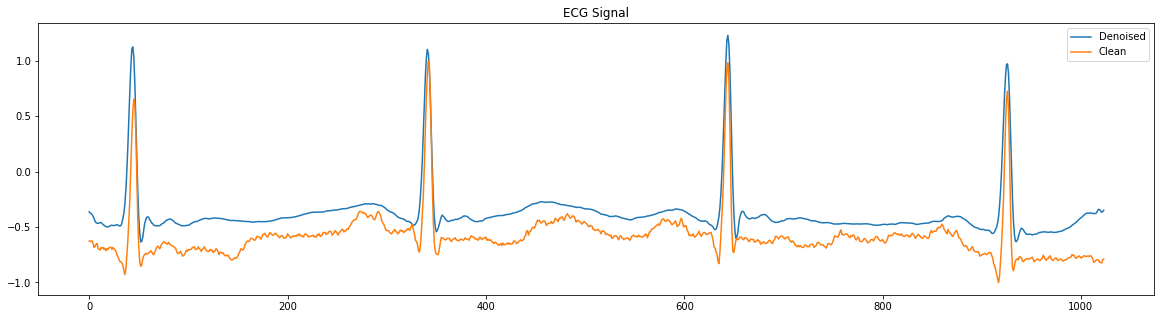

In [13]:
et.ecg_plot( [ecg_res, ecg_clean.cpu().flatten()], ['Denoised', 'Clean'])